In [1]:
import glob
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import scanpy.external as sce
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scanpy.external as sce
import pathlib
import celltypist
from celltypist import models
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 10,
    'font.family': "Arial",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 100
   }

mpl.rcParams.update(params)

sns.set_style("ticks")
sns.set_context(context='paper')
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
mpl.rc('savefig', dpi=300)
output_dir='../../figures/'
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(format='pdf', transparent=True,)
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20) 
pd.set_option('display.width', 100)
%load_ext autoreload
%autoreload 2

In [2]:
%run ../_helper.py

In [3]:
# Correlation Analysis
def convert_sparse_to_dataframe(adata):
    """ Input: anndata object with sparse matrix as .X attribute
        Returns: Pandas dataframe with rows as cells and columns as genes
        My take: Converting the data to a df inefficient but convenient and possibly more readable"""
    # Get the gene expression values for each cell x gene
    columns = adata.var.index.to_list()
    index = adata.obs.index.to_list()
    try:
        dense_array = adata.X.toarray()
    except:
        dense_array = adata.X
    df = pd.DataFrame(data=dense_array, index=index, columns=columns)
    return df

In [3]:
adatas = []
donor = 'TBd1'
for file in glob.glob("tissue_objs/*Bcells*h5ad"):
    print(file)
    # do the routine:
    # load data
    adata = sc.read_h5ad(file)
    # subsample based on being large amount of cells
    if adata.shape[0] > 100000:
        sc.pp.subsample(adata, fraction=1)
    adata = adata[adata.obs.donor == donor]
    adatas.append(adata)
adata = ad.concat(adatas)

tissue_objs/BM_Bcells_Filtered.h5ad
tissue_objs/swift_etal_Bcells_Filtered.h5ad
tissue_objs/LN_Bcells_Filtered.h5ad
tissue_objs/SP_Bcells_Filtered.h5ad
tissue_objs/PB_Bcells_Filtered.h5ad


In [4]:
adata

AnnData object with n_obs × n_vars = 25919 × 36601
    obs: 'sample_uid', 'donor', 'tissue', 'predicted_labels', 'majority_voting', 'conf_score', 'global_leiden', 'over_clustering', 'b_lineage_leiden', 'possible_predicted_labels', 'predicted_label'
    obsm: 'X_pca', 'X_umap'
    layers: 'umi_counts'

# reset X to umi counts and preprocess everyone similarly

In [ ]:
adata.obs_names_make_unique()

In [7]:
adata.X = adata.layers['umi_counts']

In [12]:
# convert cell x gene matrix to df
df = convert_sparse_to_dataframe(adata)

In [16]:
sample_uid = adata.obs.sample_uid.unique()[0]

In [18]:
cbs = adata.obs[adata.obs.sample_uid == sample_uid].index

In [19]:
heavy_chain_genes = ['IGHA1', "IGHA2", "IGHG1", "IGHG2", "IGHG3", "IGHG4", "IGHE", "IGHEP1", "IGHM", "IGHD"]

adata.obs['heavy_chain_fraction'] = df[heavy_chain_genes].sum(axis = 1) / df.sum(axis = 1)

In [22]:
fractions.cumsum()

AAACCTGAGACTCGGA-1      0.001693
AAACCTGAGCGTCAAG-1-1    0.001699
AAACCTGCAGCCTTGG-1-1    0.001705
AAACCTGCATAACCTG-1      0.001710
AAACCTGCATTCGACA-1      0.001721
                          ...   
TTTGGTTTCCTGCTTG-1      0.999943
TTTGTCAAGATGGGTC-1      0.999957
TTTGTCAAGTAAGTAC-1      0.999984
TTTGTCACACAGCCCA-1      0.999994
TTTGTCACATAACCTG-1-4    1.000000
Length: 1915, dtype: float64

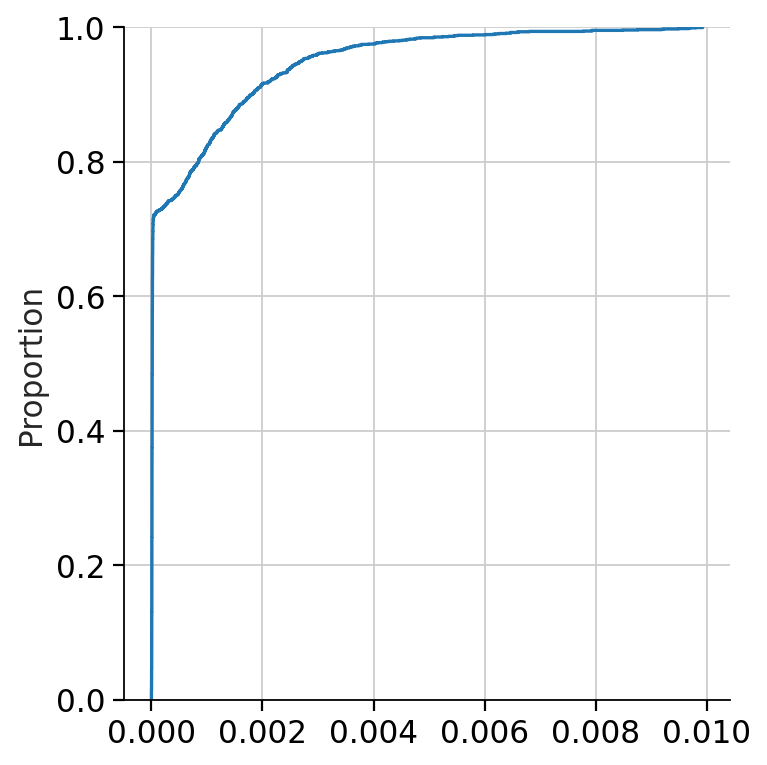

In [25]:
# look at df per sample basis
sample_df = df[df.index.isin(cbs)]
# look at heavy chain umis
sample_df_hc = sample_df[heavy_chain_genes]
# cum sum of all igh umis in the samples
cum_sum_all_igh = sample_df_hc.cumsum().sum(axis = 1).iloc[-1]
# how many igh umis each CB contributes to the dotal
fractions = sample_df_hc.sum(axis = 1) / cum_sum_all_igh
# construct df now 
sns.displot(fractions, kind = 'ecdf')

<AxesSubplot:ylabel='Proportion'>

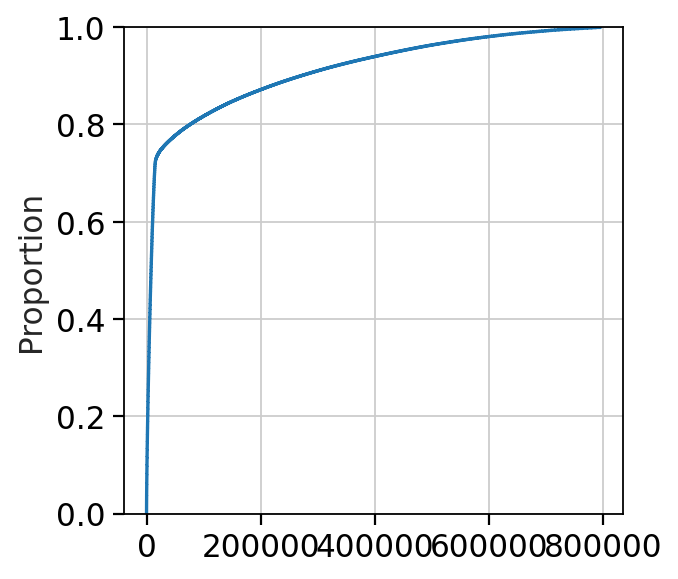

In [81]:
sns.ecdfplot(sample_df_hc.sum(axis = 1).sort_values().cumsum())

<AxesSubplot:ylabel='Proportion'>

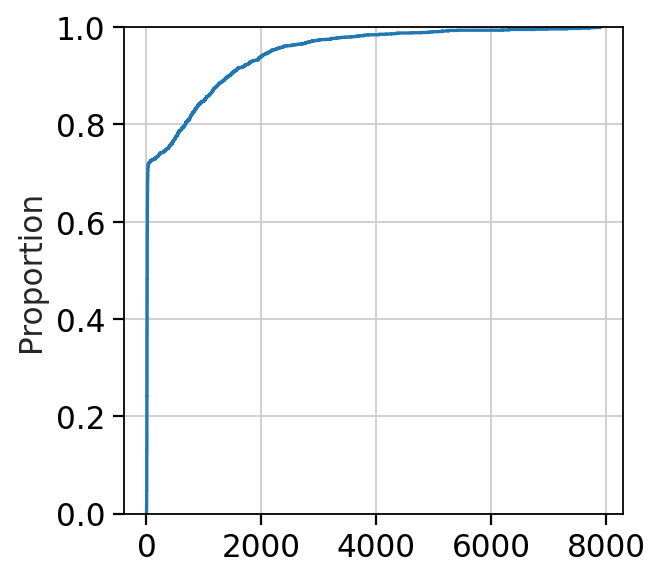

In [76]:
sns.ecdfplot(sample_df_hc.sum(axis = 1).sort_values())

In [69]:
fractions.sort_values()

CCCAATCAGTACGATA-1      0.000001
ACACTGATCACTTATC-1      0.000001
TCACAAGTCCGTTGTC-1      0.000001
CTAGCCTGTTAAGAAC-1-1    0.000001
GATCGCGTCACGCATA-1-1    0.000001
                          ...   
GTATCTTCATTCGACA-1      0.009485
CATGGCGCATCACAAC-1      0.009675
CTAACTTAGCCATCGC-1-1    0.009687
CAGCAGCTCCGCATAA-1      0.009794
CGGACTGCAGACGCCT-1      0.009922
Length: 1915, dtype: float64

<AxesSubplot:xlabel='Proportion'>

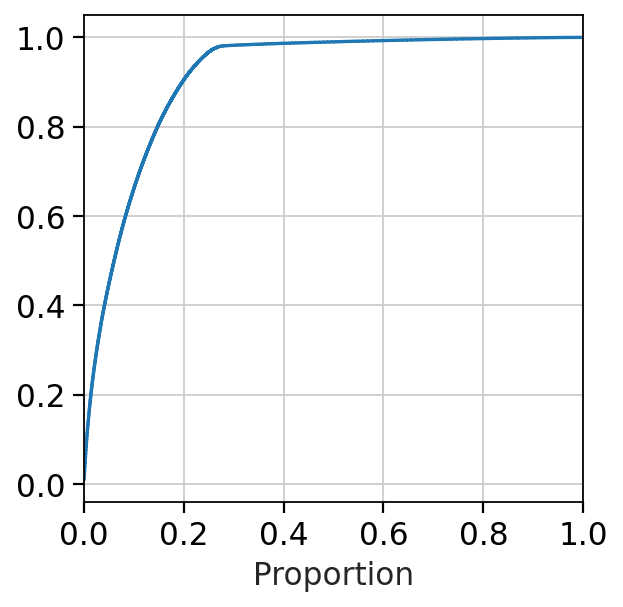

In [54]:
sns.ecdfplot(y = fractions.sort_values(ascending=False).cumsum(), stat='proportion')


In [55]:
fractions.sort_values(ascending=False)

CGGACTGCAGACGCCT-1      0.009922
CAGCAGCTCCGCATAA-1      0.009794
CTAACTTAGCCATCGC-1-1    0.009687
CATGGCGCATCACAAC-1      0.009675
GTATCTTCATTCGACA-1      0.009485
                          ...   
CGTCACTTCCGTACAA-1      0.000001
CCCAATCAGTACGATA-1      0.000001
ACACTGATCACTTATC-1      0.000001
CTGCCTAAGGTACTCT-1      0.000001
TCACAAGTCCGTTGTC-1      0.000001
Length: 1915, dtype: float64

(0.01, 1.0)

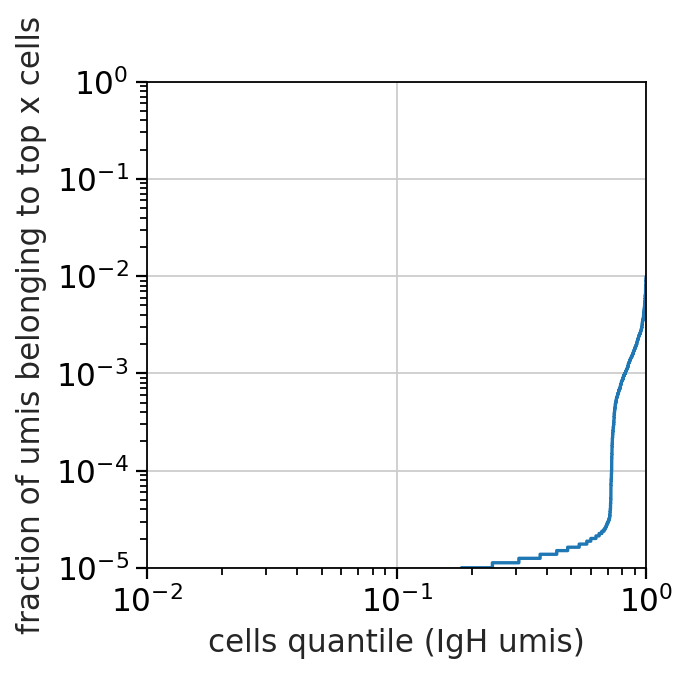

In [70]:
sns.ecdfplot(y = fractions.sort_values(ascending=False), stat='proportion')
plt.xlabel('cells quantile (IgH umis)')
plt.ylabel('fraction of umis belonging to top x cells')
plt.yscale('log')
plt.xscale('log')
plt.ylim(10**(-5), 1)
plt.xlim(10**(-2))

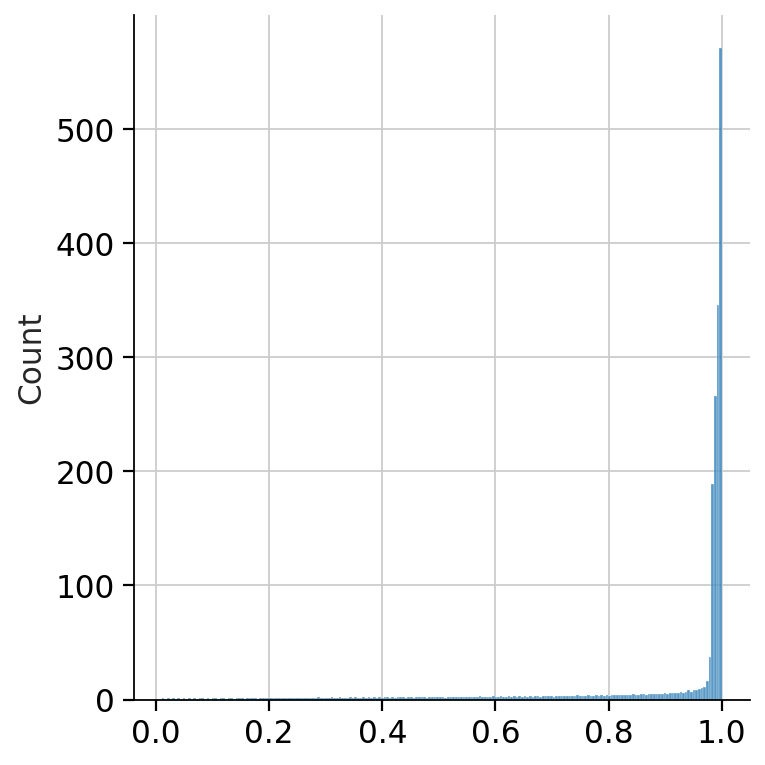

In [33]:
sns.displot(fractions.sort_values(ascending=False).cumsum())

In [37]:

df[heavy_chain_genes].cumsum()

,IGHA1,IGHA2,IGHG1,IGHG2,IGHG3,IGHG4,IGHE,IGHEP1,IGHM,IGHD
CCATGTCTCTGTCTAT-1,4.0000,0.000000,4.0000,2.00000,0.000000,0.000000,0.000000,0.000000,6.0000,1.000000
CTCGTACGTGATGTGG-1,1437.0000,13.000000,5.0000,4.00000,0.000000,0.000000,0.000000,0.000000,7.0000,1.000000
CGATGGCAGACCCACC-1-1,1437.0000,13.000000,167.0000,71.00000,2.000000,2.000000,0.000000,0.000000,7.0000,1.000000
CTTGGCTTCACCTCGT-1,1475.0000,13.000000,511.0000,349.00000,23.000000,62.000000,0.000000,0.000000,7.0000,1.000000
TTGGAACGTCCATCCT-1,1475.0000,13.000000,511.0000,349.00000,23.000000,62.000000,0.000000,0.000000,11.0000,3.000000
...,...,...,...,...,...,...,...,...,...,...
ACCGTAATCTTCATGT-1-1,628822.3125,105438.578125,397921.4375,332952.96875,100753.703125,103860.085938,6297.243164,226.548904,220409.3125,39913.265625
TAGTGGTAGATGTCGG-1-2,628823.3125,105438.578125,397921.4375,332952.96875,100754.703125,103860.085938,6297.243164,226.548904,220420.3125,39916.265625
ACGAGGATCTTAGAGC-1,628824.3125,105438.578125,397921.4375,332952.96875,100754.703125,103860.085938,6297.243164,226.548904,220424.3125,39916.265625
GCGGGTTAGATATACG-1,628825.3125,105438.578125,397921.4375,332952.96875,100754.703125,103860.085938,6297.243164,226.548904,220427.3125,39918.265625


In [38]:
df[heavy_chain_genes]

,IGHA1,IGHA2,IGHG1,IGHG2,IGHG3,IGHG4,IGHE,IGHEP1,IGHM,IGHD
CCATGTCTCTGTCTAT-1,4.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,6.0,1.0
CTCGTACGTGATGTGG-1,1433.0,13.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
CGATGGCAGACCCACC-1-1,0.0,0.0,162.0,67.0,2.0,2.0,0.0,0.0,0.0,0.0
CTTGGCTTCACCTCGT-1,38.0,0.0,344.0,278.0,21.0,60.0,0.0,0.0,0.0,0.0
TTGGAACGTCCATCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...
ACCGTAATCTTCATGT-1-1,2.0,0.0,0.0,0.0,5.0,2.0,5.0,0.0,1.0,0.0
TAGTGGTAGATGTCGG-1-2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.0,3.0
ACGAGGATCTTAGAGC-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
GCGGGTTAGATATACG-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0


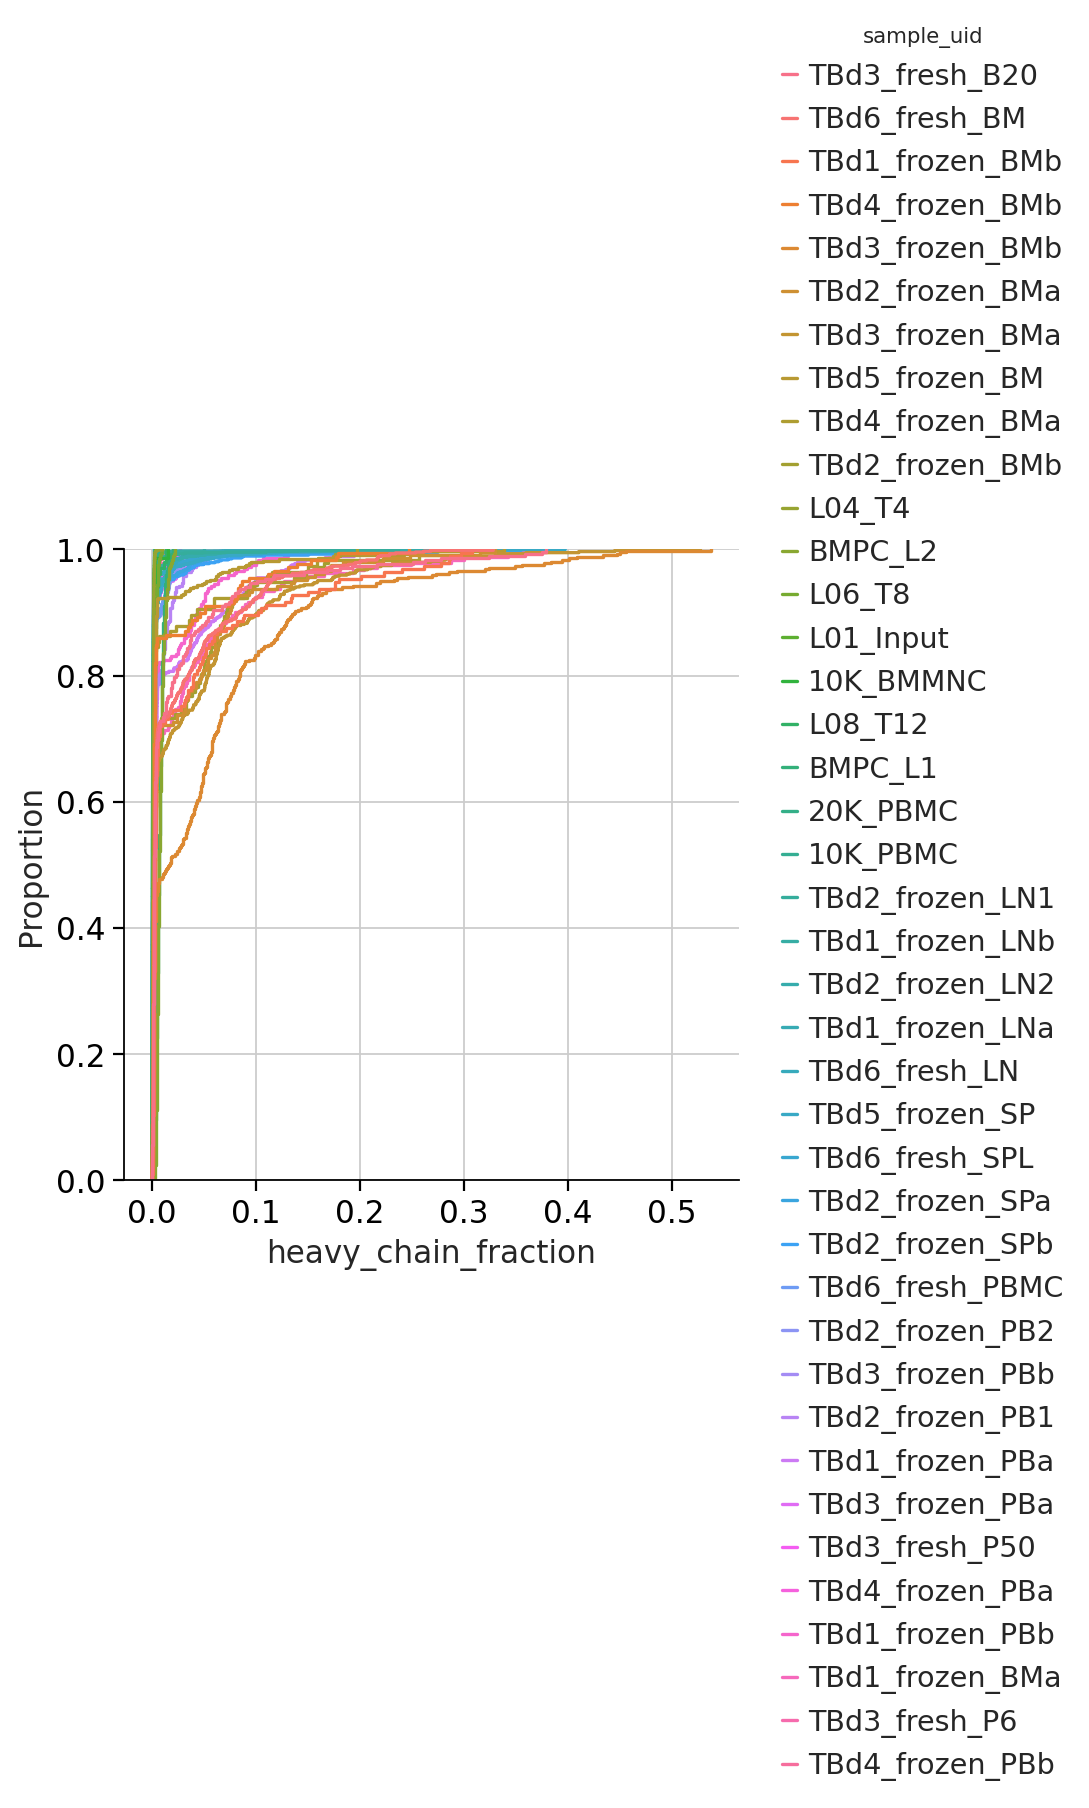

In [34]:
data = adata.obs
sns.displot(data = data, x = 'heavy_chain_fraction', hue = 'sample_uid', kind = 'ecdf')

In [9]:
adata.X = adata.layers['umi_counts']

sc.pp.calculate_qc_metrics(adata, inplace=True)

pearson_residuals = False
if pearson_residuals:
    adata = adata[:,~adata.var.index.str.contains("IGH|IGL|IGK|AC|AL")].copy()
    sc.experimental.pp.recipe_pearson_residuals(adata, batch_key='tissue')
else:
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, batch_key='donor')
    adata.raw = adata

### light-weight batch correction by choosing HVGs from different tissues



... storing 'sample_uid' as categorical
... storing 'donor' as categorical
... storing 'tissue' as categorical
... storing 'predicted_labels' as categorical
... storing 'majority_voting' as categorical
... storing 'predicted_label' as categorical


In [10]:
sc.pp.scale(adata, max_value=5)

In [11]:
sc.pp.pca(adata)

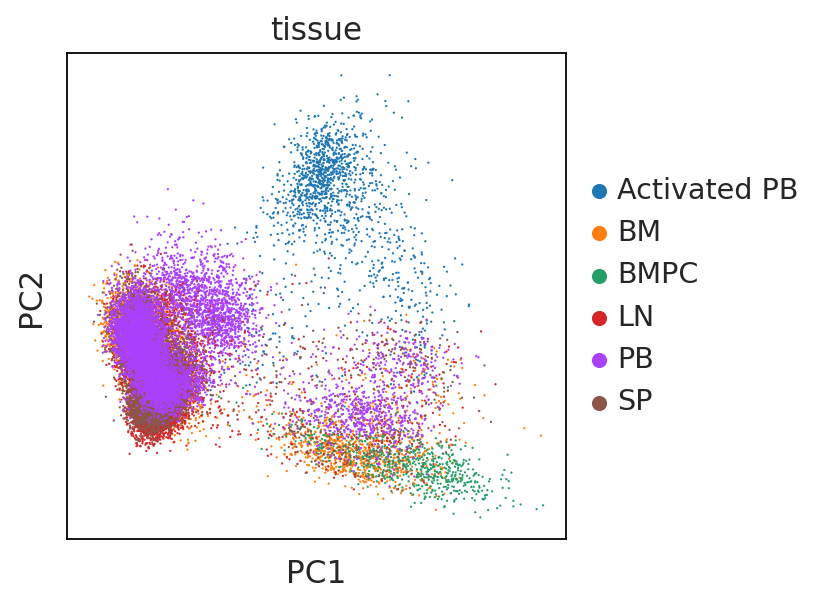

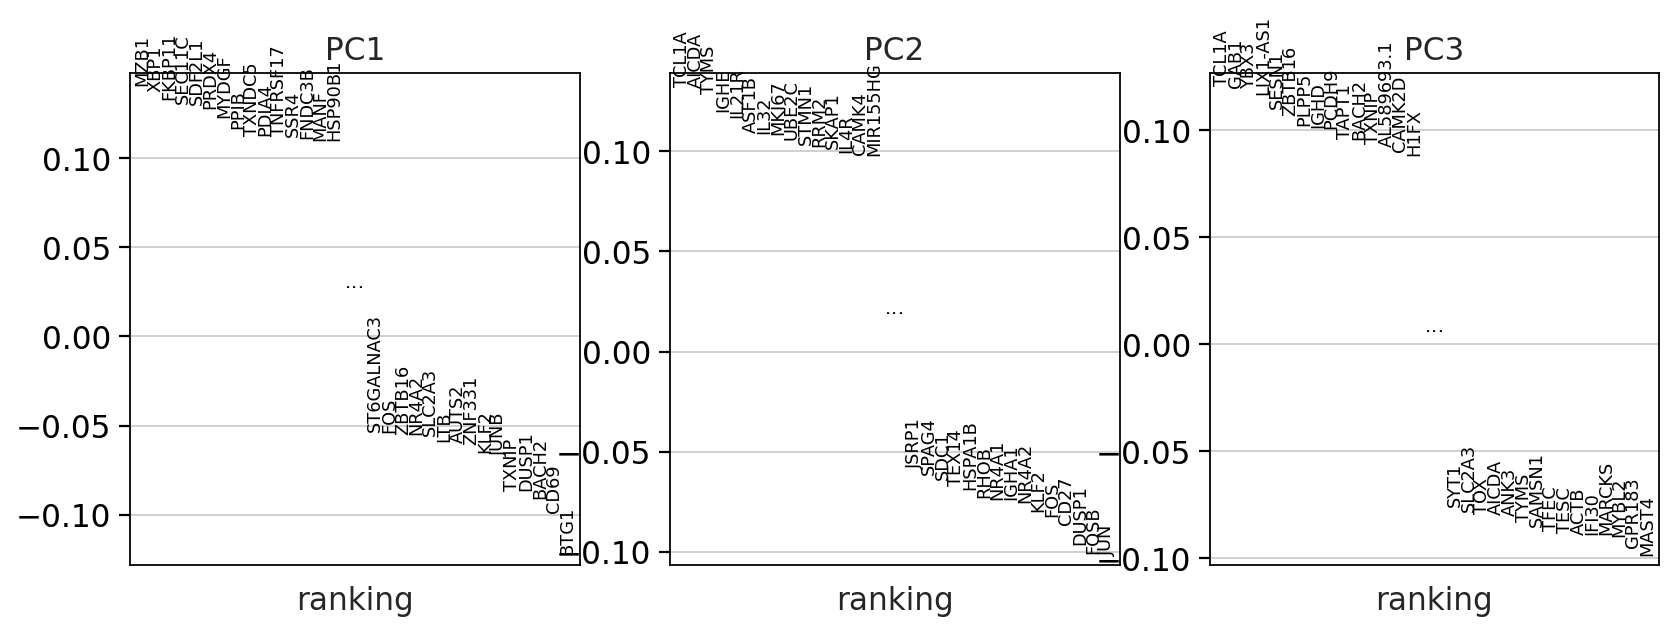

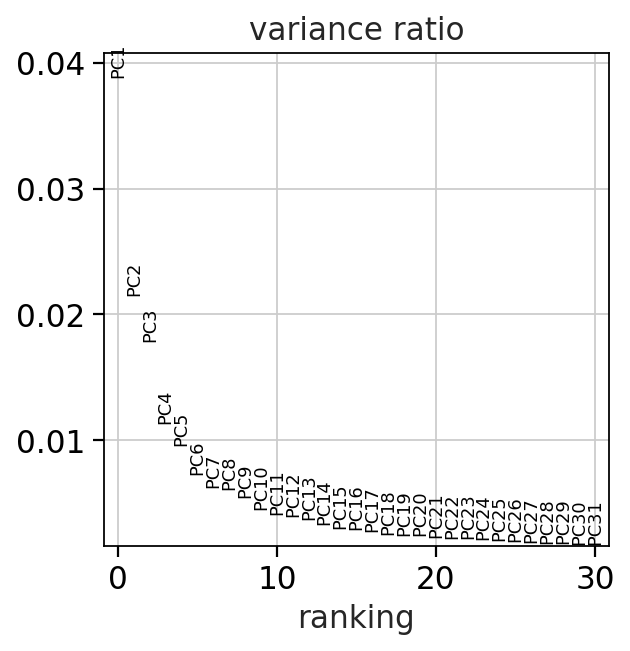

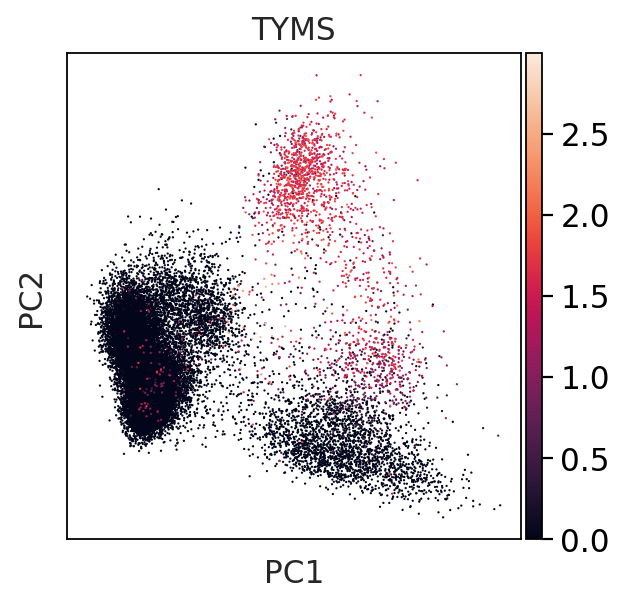

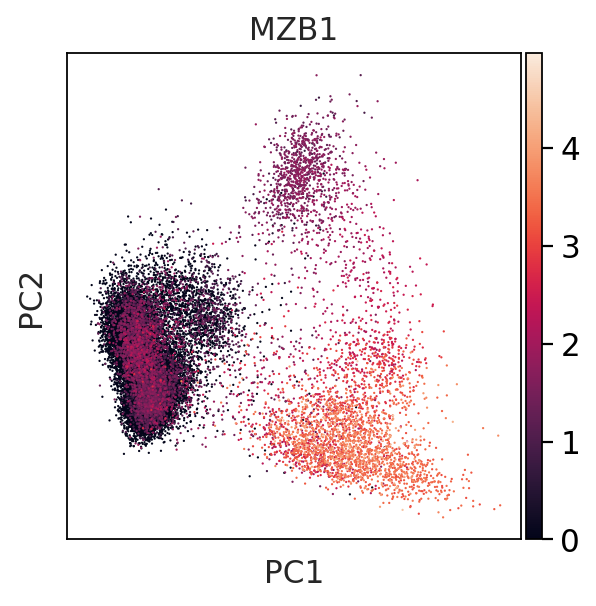

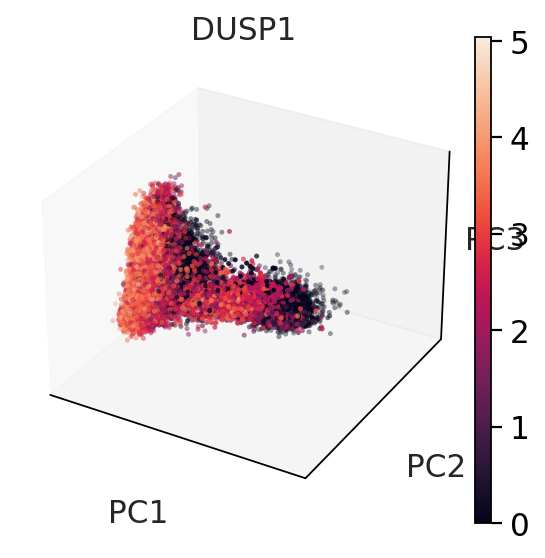

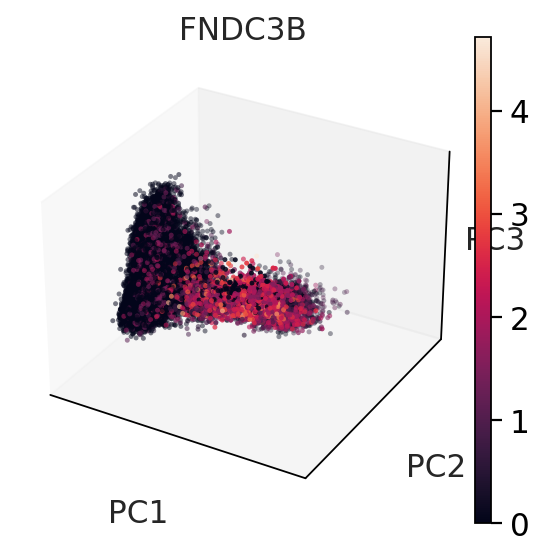

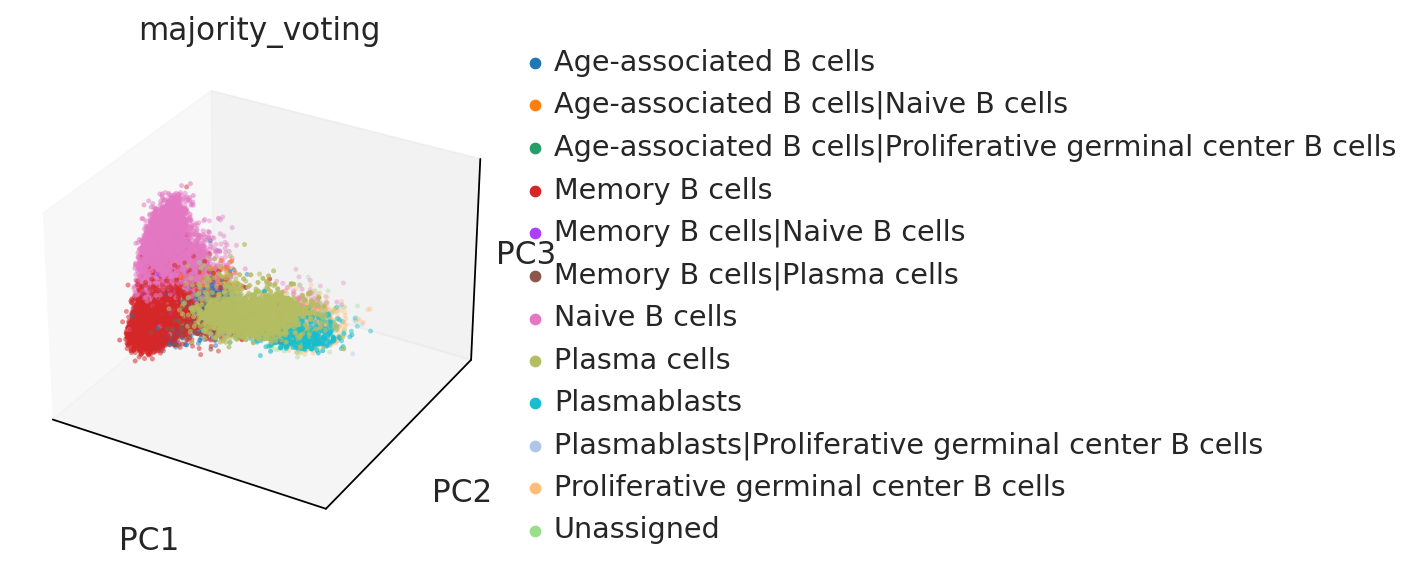

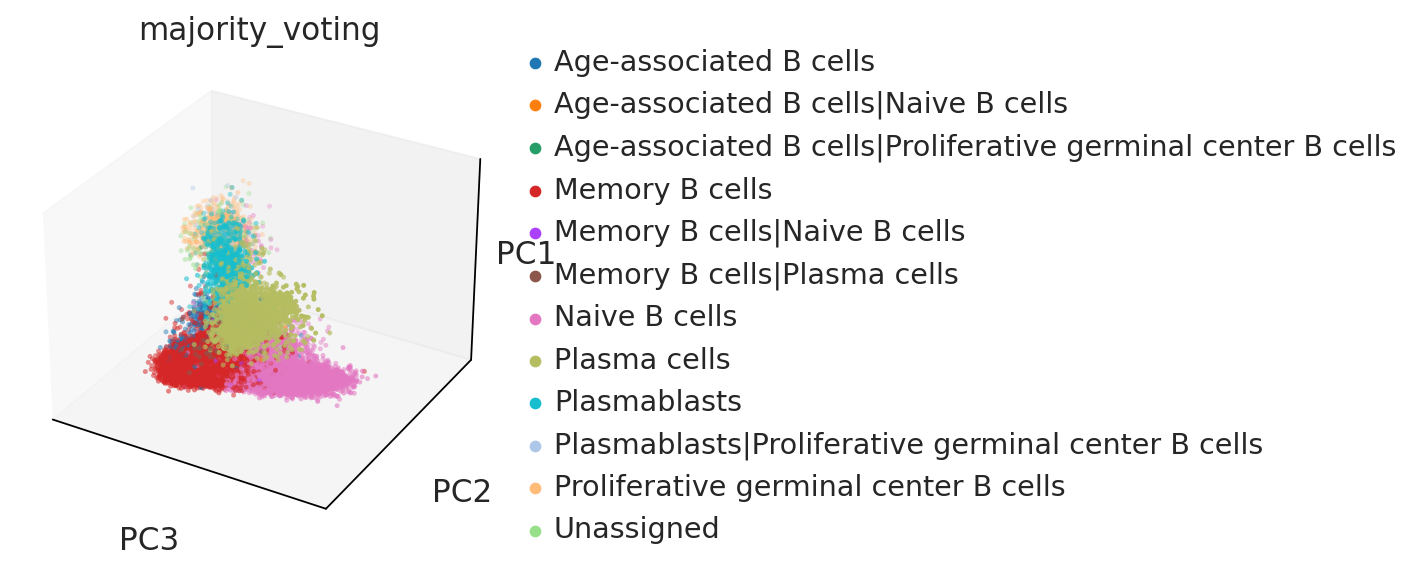

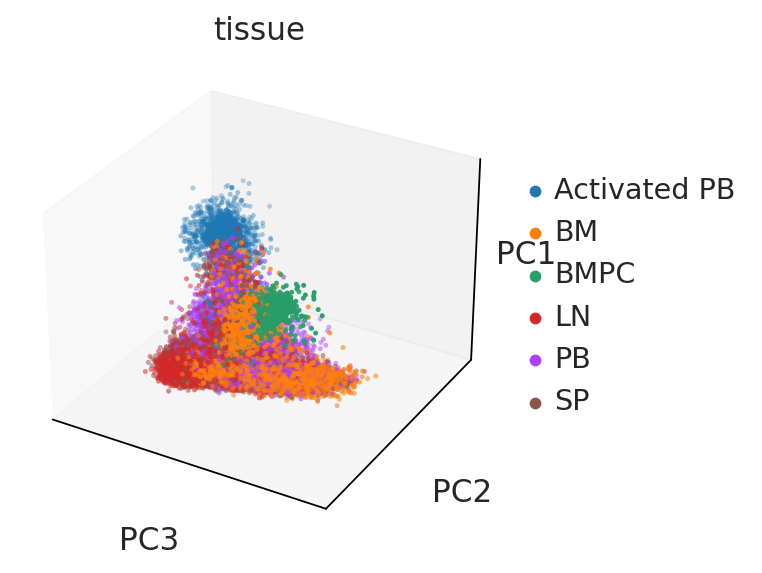

In [12]:
sc.pl.pca_overview(adata, color = 'tissue')
sc.pl.pca_scatter(adata, color = 'TYMS')
sc.pl.pca_scatter(adata, color = 'MZB1')
sc.pl.pca_scatter(adata, color = 'DUSP1', projection='3d')
sc.pl.pca_scatter(adata, color = 'FNDC3B', projection='3d')
sc.pl.pca_scatter(adata, color = 'majority_voting', projection='3d')
sc.pl.pca_scatter(adata, color = 'majority_voting', projection='3d', components='3,2,1')
sc.pl.pca_scatter(adata, color = 'tissue', projection='3d', components='3,2,1')

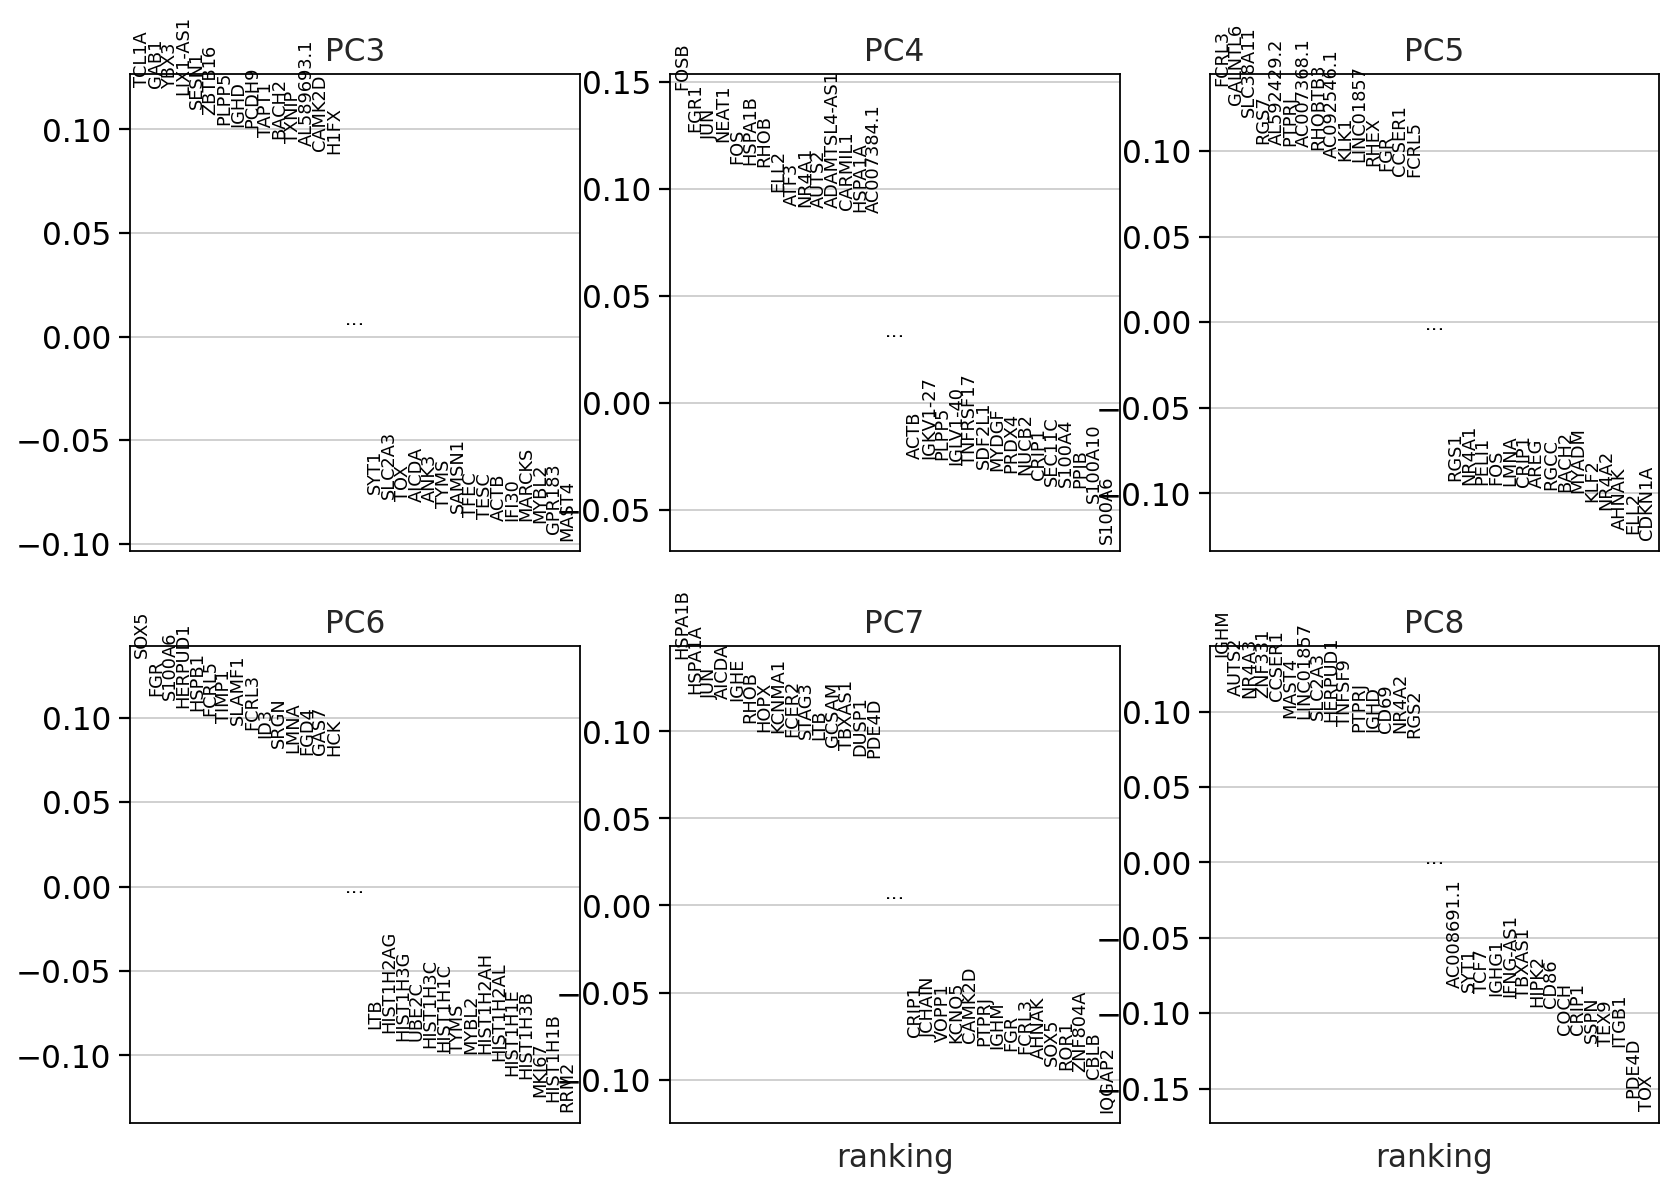

In [13]:
sc.pl.pca_loadings(adata, components='3,4,5,6,7,8')

In [15]:
adata = cluster(adata, batch_correct=False, batch_key="donor", pca = False)

drawing neighbor graph
UMAP-ing
leiden-ing


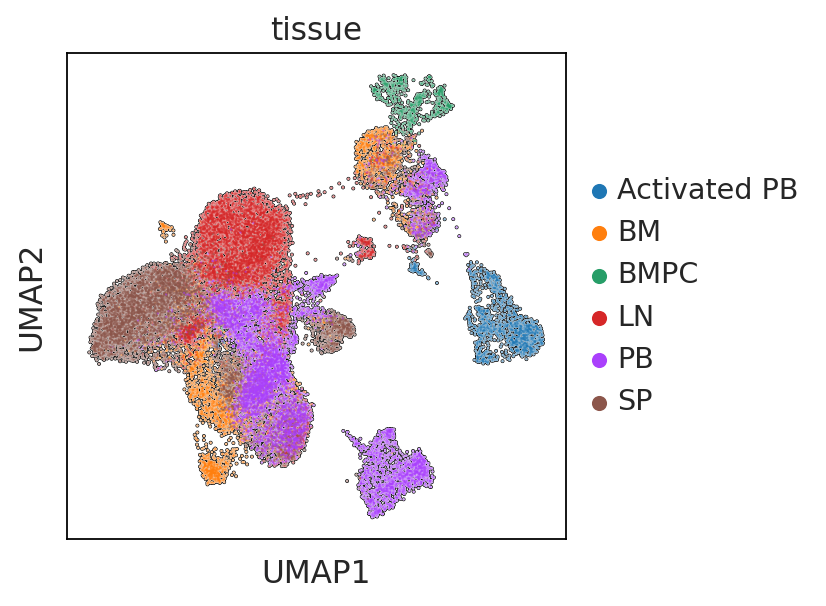

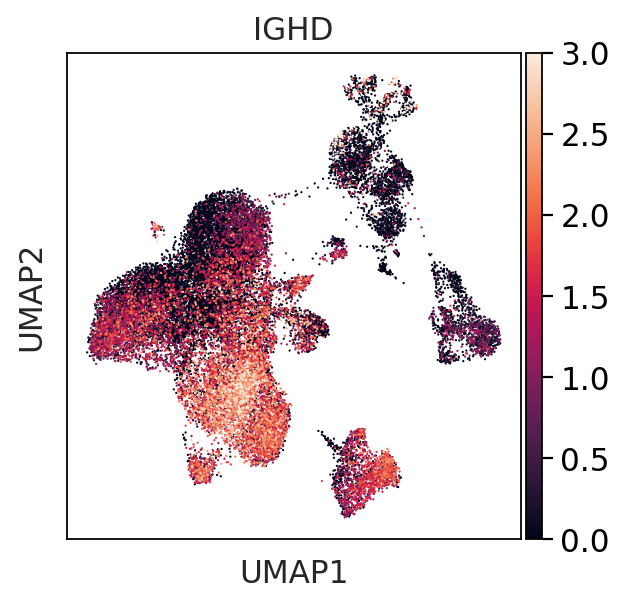

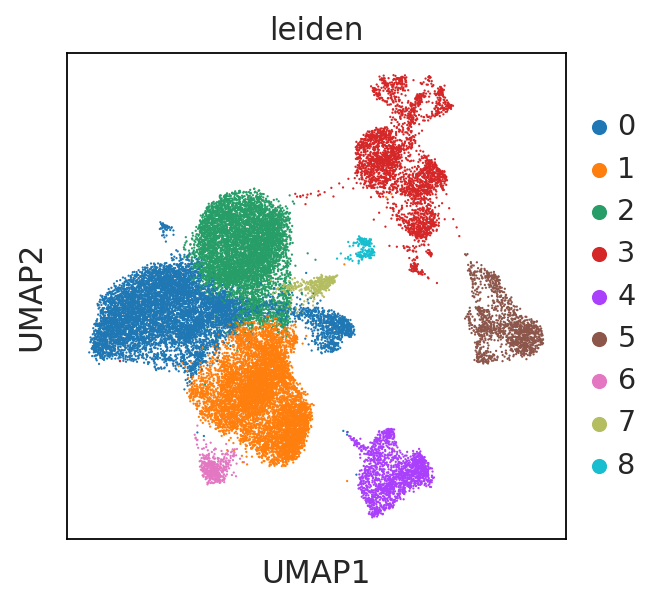

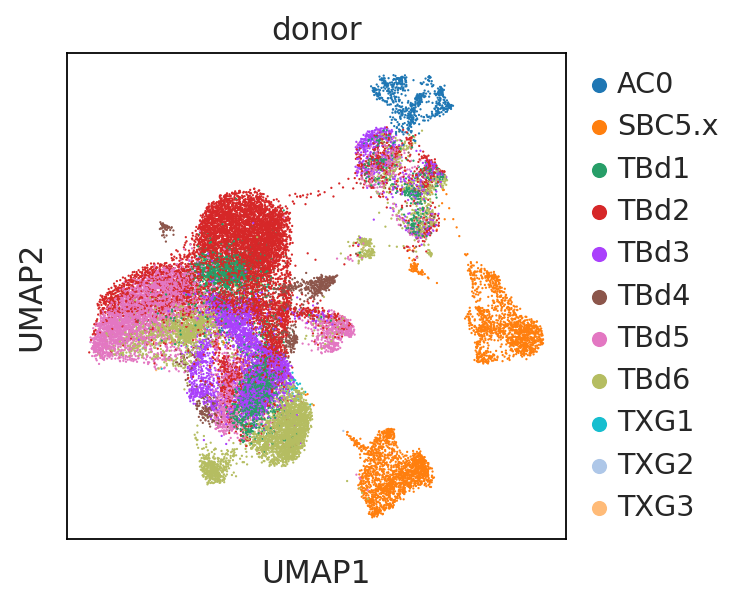

In [16]:
sc.pl.umap(adata, color = 'tissue', alpha = 0.5, add_outline=True)
sc.pl.umap(adata, color = 'IGHD', alpha = 1, vmax = 3)
sc.pl.umap(adata, color = 'leiden', alpha = 1, vmax = 3)
sc.pl.umap(adata, color = 'donor', alpha = 1, vmax = 3)

In [ ]:
#predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting=True)

#adata = predictions.adata

In [ ]:
adata.write_h5ad("bcells_BCD.h5ad")

In [ ]:
adata.obs.groupby('donor').majority_voting.value_counts().xs('SBC5.x')

In [ ]:
sc.pl.umap(adata, color = 'leiden')

sc.tl.rank_genes_groups(adata, groupby='leiden')

sc.pl.rank_genes_groups(adata)

In [ ]:
sc.pl.umap(adata, color = ['IGHM', 'IGHD', 'TMSB4X', 'AFF3', 'TXNIP', 'SSR4', 'PRDX1'])


In [ ]:
sc.tl.leiden(adata, resolution=2)

In [ ]:
sc.pl.umap(adata, color = 'leiden', size = 10)

sc.tl.rank_genes_groups(adata, groupby='leiden', reference='13')

sc.pl.rank_genes_groups(adata)

In [ ]:
sc.pl.umap(adata, color = "MKI67", vmax=1, size = 10)
sc.pl.umap(adata, color = "tissue", size=10)
sc.pl.umap(adata, color = "SDC1",size=10)

In [ ]:
sc.pl.umap(adata, color = "AICDA")

In [ ]:
group = "tissue"
label = "leiden"
color = label
data = pd.DataFrame(adata.obs.groupby([group])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.pointplot(
    y=group,
    x="proportion",
    hue=label,
    data=data,join = False, dodge=0.5, palette=adata.uns['{}_colors'.format(label)])

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")
sc.pl.umap(adata, color = 'leiden')

In [ ]:
group = "tissue"
label = "leiden"
color = label
data = pd.DataFrame(adata.obs.groupby([group])[label].value_counts(normalize=False))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.pointplot(
    y=group,
    x="proportion",
    hue=label,
    data=data,join = False, dodge=0.5, palette=adata.uns['{}_colors'.format(label)])

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Number of Cells")
plt.ylabel("sample_id")
sc.pl.umap(adata, color = 'leiden')

In [ ]:
umap_color_1_leiden(adata, '18')

In [ ]:
sc.pl.stacked_violin(adata[adata.obs.leiden == '18'], var_names = ['CCL22','MS4A1','AICDA'], groupby='sample_uid', stripplot=True)

In [ ]:
sc.pl.stacked_violin(adata, var_names = ['CCL17','MS4A1','AICDA'], groupby='tissue', stripplot=True)
sc.pl.stacked_violin(adata, var_names = ['CCL17','MS4A1','AICDA'], groupby='sample_uid', stripplot=True)

In [ ]:
sc.pl.umap(adata, color = 'majority_voting')

In [ ]:
data = pd.DataFrame(adata.obs.groupby([group, 'donor'])[label].value_counts(normalize=True))


In [ ]:
data.reset_index()

In [ ]:
data

In [ ]:
group1 = "donor"
group2 = 'tissue'
group3 = 'sample_uid'
label = "majority_voting"
color = label
data = pd.DataFrame(adata.obs.groupby([group1, group2, group3])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group1, group2, group3, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
sns.catplot(
    y=group2,
    x="proportion",
    hue=label,
    col=group1,
    data=data, kind='point', join=False, palette=adata.uns['{}_colors'.format(label)])

plt.xscale("log")
plt.xlabel("Proportion of Cells")

# Human Variation By Tissue Cell Types

In [ ]:
group1 = "donor"
group2 = 'tissue'
group3 = 'sample_uid'
label = "majority_voting"
color = label
data = pd.DataFrame(adata.obs.groupby([group1, group2, group3])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group1, group2, group3, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
sns.catplot(
    y=group2,
    x="proportion",
    hue=label,
    data=data, kind='swarm',palette=adata.uns['{}_colors'.format(label)], aspect=2)

plt.xscale("log")
plt.xlabel("Proportion of Cells")

In [ ]:
group1 = "donor"
group2 = 'tissue'
group3 = 'sample_uid'
label = "majority_voting"
color = label
data = pd.DataFrame(adata.obs.groupby([group1, group2, group3])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group1, group2, group3, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
sns.catplot(
    y=group2,
    x="proportion",
    hue=group1,
    col = label,
    data=data, kind='strip',palette=adata.uns['{}_colors'.format(label)], aspect=2)

plt.xscale("log")
plt.xlabel("Proportion of Cells")

In [ ]:
group1 = "donor"
group2 = 'tissue'
group3 = 'sample_uid'
label = "majority_voting"
color = label
data = pd.DataFrame(adata.obs.groupby([group1, group2, group3])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group1, group2, group3, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
sns.catplot(
    y=group2,
    x="proportion",
    hue=label,
    data=data, kind='box',palette=adata.uns['{}_colors'.format(label)], aspect=2, height=5)

plt.xscale("log")
plt.xlabel("Proportion of Cells")

In [ ]:
group1 = "donor"
group2 = 'tissue'
group3
label = "majority_voting"
color = label
data = pd.DataFrame(adata.obs.groupby([group1, group2])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group1, group2, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
g = sns.catplot(
    y=group2,
    x="proportion",
    hue=label,
    data=data, kind='swarm', palette=adata.uns['{}_colors'.format(label)], height=7, aspect=1.5)

plt.xscale("log")
plt.xlabel("Proportion of Cells")

In [ ]:
group = "tissue"
label = "majority_voting"
color = label
data = pd.DataFrame(adata.obs.groupby([group])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.pointplot(
    y=group,
    x="proportion",
    hue=label,
    data=data,join = False, dodge=0.5, palette=adata.uns['{}_colors'.format(label)])

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")
sc.pl.umap(adata, color = 'leiden')
hm = data.pivot(index = group, columns=label)
sns.clustermap(hm, figsize=(12,12))

In [ ]:
group = "sample_uid"
label = "leiden"
color = label
data = pd.DataFrame(adata.obs.groupby([group])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = [group, label,"proportion"]
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,10))

sns.pointplot(
    y=group,
    x="proportion",
    hue=label,
    data=data,join = False, dodge=0.5, palette=adata.uns['{}_colors'.format(label)])

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")
sc.pl.umap(adata, color = 'leiden')

hm = data.pivot(index = 'sample_uid', columns='leiden')

sns.clustermap(hm)

In [ ]:
scipy.stats.spearmanr

In [ ]:
sub_data = data[data.proportion > 0.03]
sub_data.celltype = sub_data.celltype.cat.remove_unused_categories()
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.barplot(
    y="sample_id",
    x="proportion",
    hue="celltype",
    data=sub_data,)

#plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")


fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.pointplot(
    y="sample_id",
    x="proportion",
    hue="celltype",
    data=sub_data,join = False, dodge=0.2, palette='Dark2')

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")


In [ ]:
adata.write_h5ad("bcells.h5ad")

In [ ]:
def ecdf_compare_bg(adata, gene):
    _umi = sc.get.obs_df(bcells, keys = gene, layer='umi_counts')
    _bg = sc.get.obs_df(bcells, keys = gene, layer='background_removed')
    data = pd.concat([_bg, _umi], axis=1)
    data.columns = ['cbender', 'umi']
    data = data.melt()
    sns.displot(data, x = 'value', hue = 'variable', kind = 'ecdf', log_scale=True)

In [ ]:
adata = sc.read_h5ad('bcells.h5ad')

## Tissue Analysis

In [ ]:
import os

In [ ]:
_sub_adata = adata[adata.obs[column_name] == cell_type]
# subset to tissues with more than 10 cells detected in this class
# for reasonable differential epxression comparison
_df = pd.DataFrame(_sub_adata.obs.groupby(label)[column_name].value_counts() > 10)
_tissues = _df[_df[column_name] == True].unstack().index.to_list()
_sub_adata = _sub_adata[_sub_adata.obs.tissue.isin(_tissues)]
print("{} {} in the dataset {}".format(_sub_adata.obs.shape[0], cell_type, "after filtering out low abundance tissues"))

print("performing differential expression analysis")
min_fold_change = 0.8
# uses t-test for speed, but wilcoxon is the more appropriate test I'm told
sc.tl.rank_genes_groups(_sub_adata, groupby=label)
sc.tl.filter_rank_genes_groups(_sub_adata, min_fold_change=min_fold_change)
print("filtered genes by min fold change {}".format(min_fold_change))

sc.pl.rank_genes_groups(_sub_adata)
result = _sub_adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
gene_df = pd.DataFrame(
    {group + '_' + key[:]: result[key][group]
     # Get Each Clusters 10 top Genes
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

holo_gene_set = []
num_genes = 20
result = _sub_adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
gene_df = pd.DataFrame(
    {group + '_' + key[:]: result[key][group]
     # Get Each Clusters 10 top Genes
    for group in groups for key in ['names', 'pvals']})


#iterate thru the unique tissues
for tis in _sub_adata.obs[label].unique():

    # reset rank genes df for new organ
    _gene_df = gene_df.copy()
     # Drop the filtered genes
    _gene_df = _gene_df[[tis + '_names', tis + '_pvals']].dropna()
    gene_list = _gene_df[tis + '_names'].to_list()
    genes = gene_list
    holo_gene_set.append(gene_list)
    score_name = tis + '_' + cell_type + "_residence_score"
    sc.tl.score_genes(_sub_adata, gene_list = gene_list[:num_genes], score_name = score_name, use_raw = False)
    plotdf = sc.get.obs_df(
            _sub_adata,
            keys=genes + [label, score_name])
    for gene in genes[:2]:
        g = sns.displot(data = plotdf, x = gene, hue = label, kind='ecdf', palette=tissue_colors_dictionary
                   )
        g.set_titles(cell_type)
        g.set_xlabels(gene + ' expression')
        directory = 'figures/{}_specific/{}_{}/'.format(label, cell_type, tis)
        if not os.path.exists(directory):
            os.makedirs(directory)
        g.savefig('figures/{}_specific/{}_{}/{}.pdf'.format(label, cell_type, tis, gene))
    g = sns.displot(data = plotdf, x=score_name, hue = label, kind = 'ecdf', palette=tissue_colors_dictionary )
    g.savefig('figures/{}_specific/{}.pdf'.format(label, score_name))

In [ ]:
sc.pl.rank_genes_groups_dotplot(_sub_adata)

In [ ]:
## Do Plasmablasts in Blood express JCHAIN no matter their isotype what?

In [ ]:
import celltypist

In [ ]:
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl',
                                  majority_voting=True, mode = 'prob match')

In [ ]:
adata = predictions.to_adata()

In [ ]:
tissue_colors_dictionary = tissue_colors()

In [ ]:
cell_type = "Plasma cells"
label = "tissue"
column_name = "predicted_label"